# Neural encoding of distributions

This notebook explores encoding probability distributions in a compressed representation using autoencoder-ish neural network models. If does well, the encoder can feed in the ensemble models.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from pathlib import Path
sys.path.append("../../src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import data

from keras.layers import (Activation, Convolution1D, Convolution2D, Dense,
                          Dropout, Embedding, Flatten, Merge)
from keras.models import Sequential
from keras.regularizers import l2

from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split

Using Theano backend.


## Load data

In [3]:
kcde_dl = data.ComponentDataLoader("../../data", "kcde")
kde_dl = data.ComponentDataLoader("../../data", "kde")
sarima_dl = data.ComponentDataLoader("../../data", "sarima")

In [4]:
# Try a single model with one week ahead distributions
# Skip the last bin
X = np.exp(kcde_dl.get(1)[1][:, :-1])

X_train, X_test = train_test_split(X, test_size=0.2, random_state=1234)

## Simple fully connected model

In [5]:
def dist_enc():
    model = Sequential()
    model.add(Dense(10, input_shape=(130,)))
    model.add(Activation("relu"))
    model.add(Dense(5))
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("relu"))
    model.add(Dense(130))
    model.add(Activation("softmax"))
    return model

In [6]:
model = dist_enc()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                1310      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 130)               1430      
__________

In [7]:
model.compile(optimizer="rmsprop", loss="mse")

In [8]:
history = model.fit(X_train, X_train,
                    batch_size=64, epochs=50,
                    verbose=1,
                    validation_data=(X_test, X_test))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Train on 3717 samples, validate on 930 samples
Epoch 1/50
3717/3717 [==============================] - 0s - loss: 5.3009e-04 - val_loss: 5.4194e-04
Epoch 2/50
3717/3717 [==============================] - 0s - loss: 4.8378e-04 - val_loss: 4.7837e-04
Epoch 3/50
3717/3717 [==============================] - 0s - loss: 4.1770e-04 - val_loss: 4.2669e-04
Epoch 4/50
3717/3717 [==============================] - 0s - loss: 3.8051e-04 - val_loss: 3.9440e-04
Epoch 5/50
3717/3717 [==============================] - 0s - loss: 3.5127e-04 - val_loss: 3.6427e-04
Epoch 6/50
3717/3717 [==============================] - 0s - loss: 3.2921e-04 - val_loss: 3.4714e-04
Epoch 7/50
3717/3717 [==============================] - 0s - loss: 3.1463e-04 - val_loss: 3.3325e-04
Epoch 8/50
3717/3717 [==============================] - 0s - loss: 3.0024e-04 - val_loss: 3.1805e-04
Epoch 9/50
3717/3717 [==============================] - 0s - loss: 2.8226e-04 - val_loss: 2.9948e-04
Epoch 10/50
3717/3717 [=====================

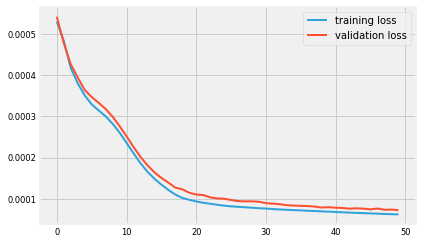

In [9]:
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()

In [10]:
model.evaluate(X_test, X_test)

 32/930 [>.............................] - ETA: 0s

7.2411233732934979e-05

## Predictions

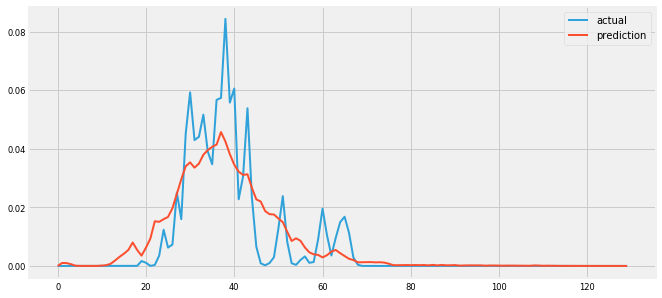

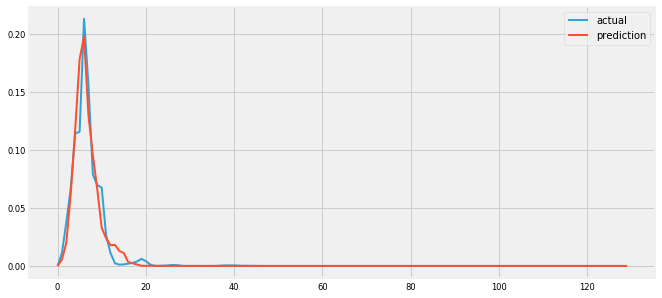

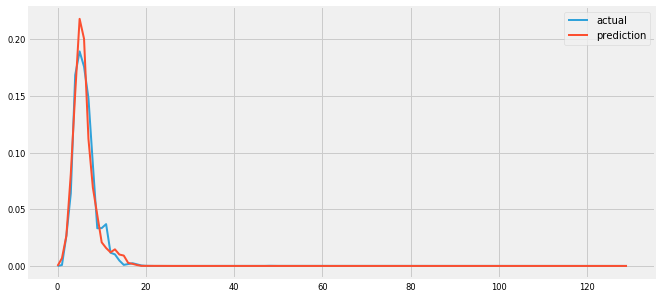

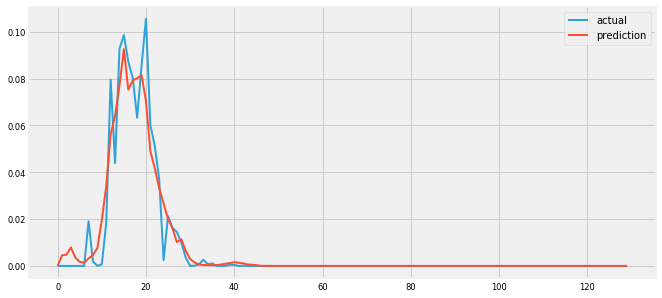

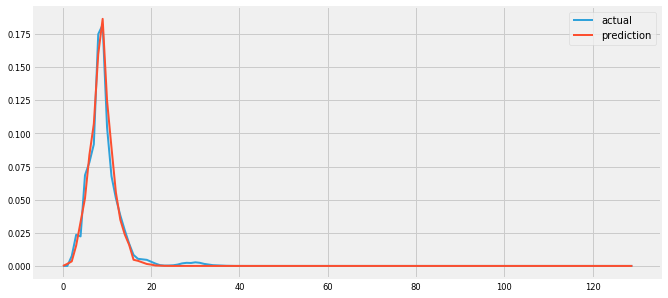

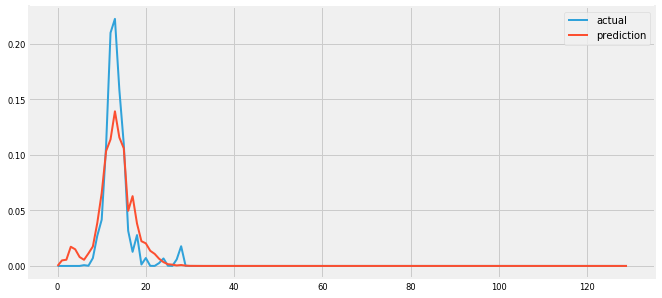

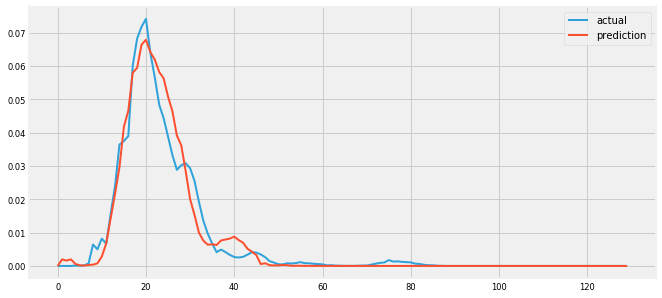

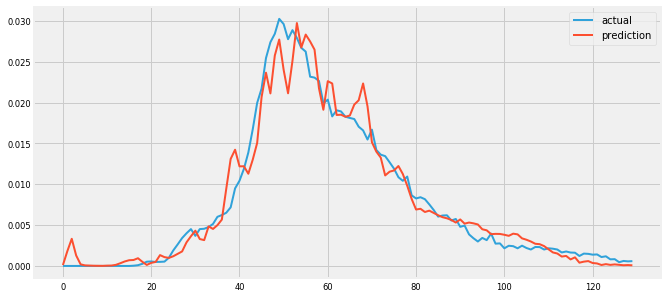

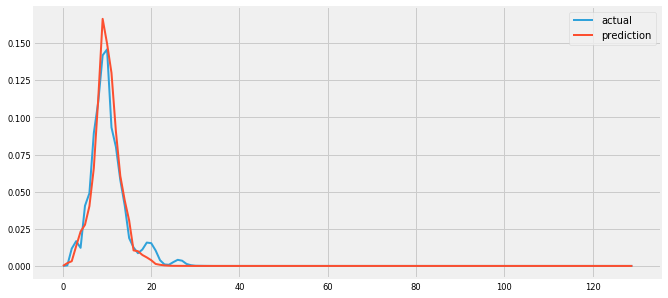

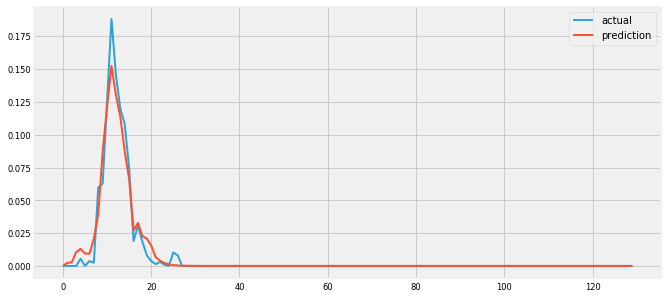

In [11]:
test_points = np.random.randint(0, X_test.shape[0], size=(10,))
test_predictions = model.predict(X_test[test_points])

for i, tp in enumerate(test_points):
    plt.figure(figsize=(10, 5))
    plt.plot(X_test[tp, :], label="actual")
    plt.plot(test_predictions[i, :], label="prediction")
    plt.legend()

## Function for encoded output

In [13]:
from keras import backend as K

In [26]:
get_encoding = K.function([model.layers[0].input], [model.layers[3].output])

In [27]:
get_encoding([X_test[test_points]])[0]

array([[ 1.29607487,  2.89079618,  0.72721809,  0.37155247,  1.31541789],
       [ 1.03006911,  1.27311325,  2.56645513,  4.16794062,  3.12375069],
       [ 1.15118742,  1.08822441,  2.63373899,  4.06131029,  2.74421549],
       [ 0.96265471,  3.04848862,  1.42173564,  2.13943052,  3.38107944],
       [ 0.65586853,  2.4923296 ,  3.1013    ,  4.74169302,  4.91297817],
       [ 1.18144417,  3.6408124 ,  3.02110004,  3.34948802,  4.54052734],
       [ 0.95785046,  3.184618  ,  1.06040525,  1.18229938,  2.68628645],
       [ 1.60122848,  1.57333994,  0.3520512 ,  0.37536344,  0.24802859],
       [ 0.65351498,  2.93230343,  3.06633544,  4.39946508,  5.04513407],
       [ 0.85477561,  3.6667695 ,  3.24365067,  3.88099432,  5.17840862]], dtype=float32)